In [1]:
%load_ext autoreload
%autoreload 2

import os
import time

import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from utils import downgrade_lightcone, read_cosmo_params

from tqdm import tqdm

In [2]:
nside = 2048 #nside for the healpix map

# Explore Gower Street Simulations

This notebook is meant to get familiar with the Gower Street simulations output (e.g. lightcones).

In [3]:
path_sims = "/n17data/sguerrini/GowerStreetSims/"
sim = 1
run = 75

def get_path_lightcone(sim, run):
    path = path = os.path.expanduser(path_sims + "sim{:05d}/".format(sim) + "run.{:05d}.lightcone.npy".format(run))
    return os.path.exists(path), path

def get_path_redshifts(sim):
    path = os.path.expanduser(path_sims + "sim{:05d}/".format(sim) + "z_values.txt")
    return os.path.exists(path), path

In [4]:
path_exist, path = get_path_lightcone(sim, run)

print(f"The path {path} exists.") if path_exist else print(f"The path {path} does not exist. Check the path and try again.")

The path /n17data/sguerrini/GowerStreetSims/sim00001/run.00075.lightcone.npy exists.


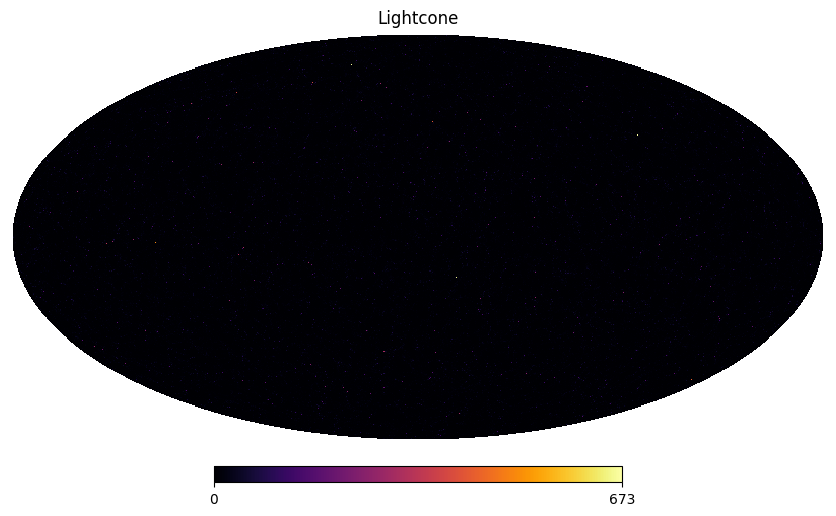

In [5]:
data = np.load(path, allow_pickle=True)

hp.mollview(data, title="Lightcone", cmap="inferno")
plt.show()

In [6]:
print("Number of objects in the lightcone: ", np.sum(data))

Number of objects in the lightcone:  221485639


In [7]:
#Compute the density contrast
mean_pix = np.mean(data)
delta = data/mean_pix - 1

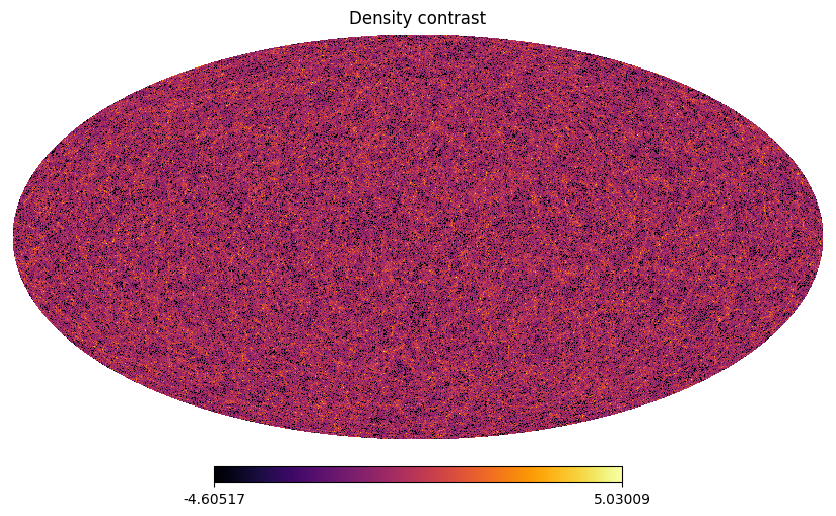

In [8]:
hp.mollview(np.log(1+0.01+delta), title="Density contrast", cmap="inferno")
plt.show()

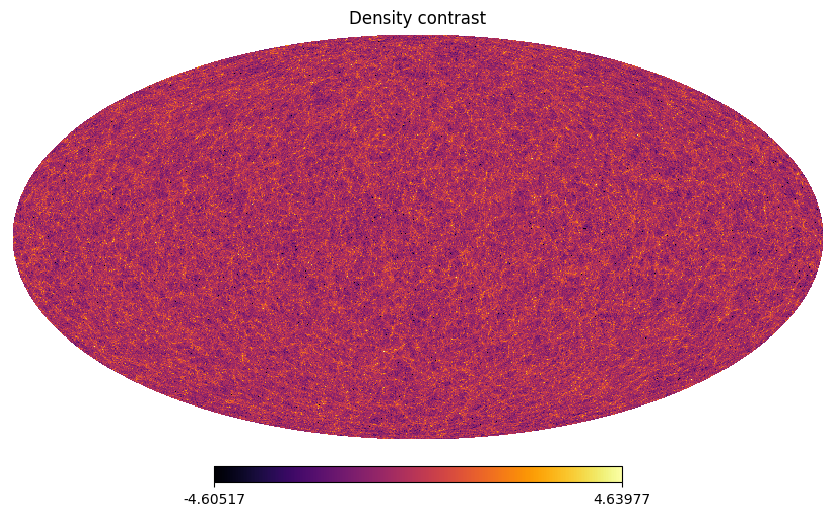

In [9]:
delta_dg = downgrade_lightcone(delta, 1024)

hp.mollview(np.log(1+0.01+delta_dg), title="Density contrast", cmap="inferno")
plt.show()

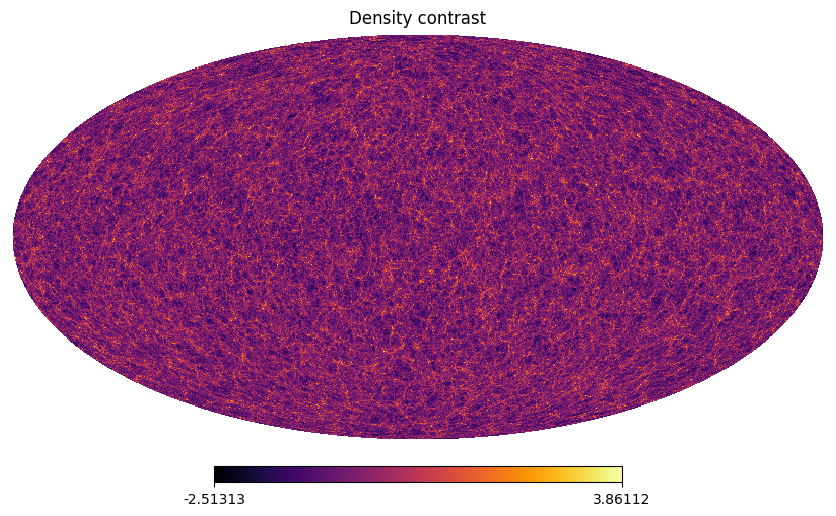

In [10]:
delta_dg = downgrade_lightcone(delta_dg, 512)

hp.mollview(np.log(1+0.01+delta_dg), title="Density contrast", cmap="inferno")
plt.show()

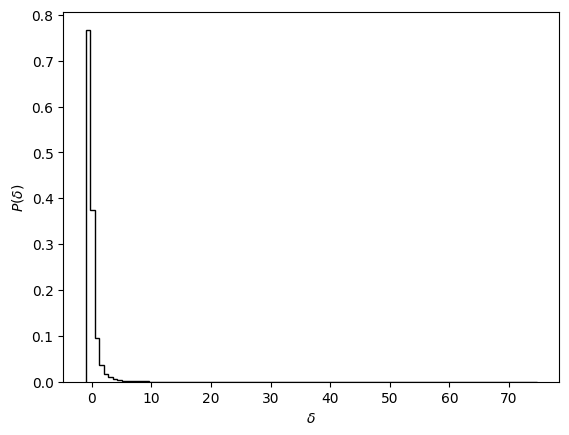

In [13]:
#PDF of the density contrast

plt.figure()

plt.hist(delta_dg, bins=100, density=True, histtype="step", color="black")
plt.xlabel(r"$\delta$")
plt.ylabel(r"$P(\delta)$")
plt.show()

In [14]:
#Analyze the redshift distribution
path_exist, redshift_file = get_path_redshifts(sim)

print(f"The path {redshift_file} exists.") if path_exist else print(f"The path {redshift_file} does not exist. Check the path and try again.")

The path /n17data/sguerrini/GowerStreetSims/sim00001/z_values.txt exists.


In [15]:
redshifts = pd.read_csv(redshift_file, sep=",")
redshifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   # Step            100 non-null    int64  
 1   z_far             100 non-null    float64
 2   z_near            100 non-null    float64
 3   delta_z           100 non-null    float64
 4   cmd_far(Mpc/h)    100 non-null    float64
 5   cmd_near(Mpc/h)   100 non-null    float64
 6   delta_cmd(Mpc/h)  100 non-null    float64
 7   cmd/box_far       100 non-null    float64
 8   cmd/box_near      100 non-null    float64
 9   delta_cmd/box     100 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 7.9 KB


In [16]:
redshifts.head()


# Step     z_far    z_near   delta_z  cmd_far(Mpc/h)  cmd_near(Mpc/h)  \
0       1  49.00000  19.62800  29.37200     8470.535928      7593.780321   
1       2  19.62800  13.28560   6.34240     7593.780321      7099.598583   
2       3  13.28560  10.28740   2.99820     7099.598583      6731.627796   
3       4  10.28740   8.48685   1.80055     6731.627796      6431.149236   
4       5   8.48685   7.26564   1.22121     6431.149236      6173.781659   

   delta_cmd(Mpc/h)  cmd/box_far  cmd/box_near  delta_cmd/box  
0        876.755607     6.776429      6.075024       0.701404  
1        494.181738     6.075024      5.679679       0.395345  
2        367.970787     5.679679      5.385302       0.294377  
3        300.478560     5.385302      5.144919       0.240383  
4        257.367577     5.144919      4.939025       0.205894

In [17]:
redshifts.loc[redshifts["# Step"]==100-77]

# Step    z_far   z_near  delta_z  cmd_far(Mpc/h)  cmd_near(Mpc/h)  \
22      23  2.16565  2.07237  0.09328     3821.125074      3730.435705   

    delta_cmd(Mpc/h)  cmd/box_far  cmd/box_near  delta_cmd/box  
22         90.689369       3.0569      2.984349       0.072551

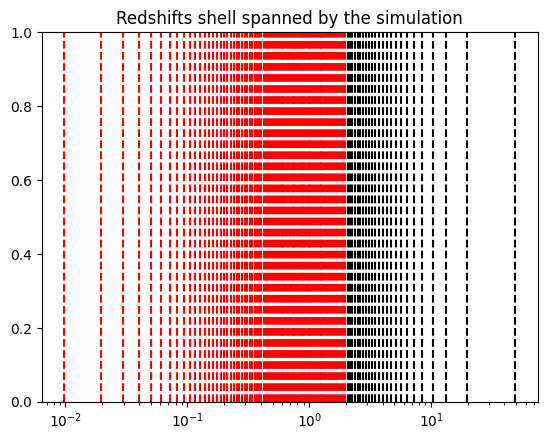

In [18]:
sim = 1

shells = []

plt.figure()

for step, z in enumerate(redshifts["z_far"]):
    path_exist, _ = get_path_lightcone(sim, step)
    if path_exist:
        shells.append(z)
    plt.axvline(x=z, color="black", linestyle="--") if not path_exist else \
        plt.axvline(x=z, color="red", linestyle="--")

shells.append(0.0)

shells = np.array(shells[::-1])

plt.title("Redshifts shell spanned by the simulation")
plt.xscale('log')
plt.show()

In [20]:
#Reproduce Figure 2 in Jeffrey et al.

sim = 2
nside=512

density_contrast = np.zeros(hp.nside2npix(nside))

n_shell = 0
for step, z in tqdm(enumerate(redshifts["z_near"])):
    path_exist, path = get_path_lightcone(sim, step)
    if path_exist and z<0.15:
        gal_count_per_pix = np.load(path, allow_pickle=True)
        mean_pix = np.mean(gal_count_per_pix)
        delta = gal_count_per_pix/mean_pix - 1
        delta = downgrade_lightcone(delta, 1024)
        delta = downgrade_lightcone(delta, 512)
        density_contrast = density_contrast + delta
        del delta
        n_shell += 1

print(f"Number of shells spanned: {n_shell}")
density_contrast /= n_shell

100it [01:54,  1.14s/it]

Number of shells spanned: 14


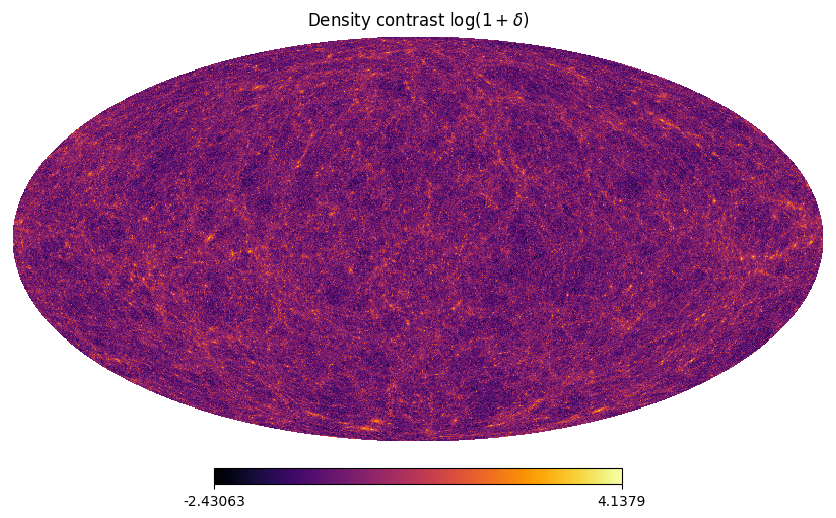

In [21]:
cmap = LinearSegmentedColormap.from_list("mycmap", ["black", "gray"])

hp.mollview(np.log(1.0+density_contrast), title="Density contrast $\log(1+\delta)$", cmap="inferno")
plt.show()

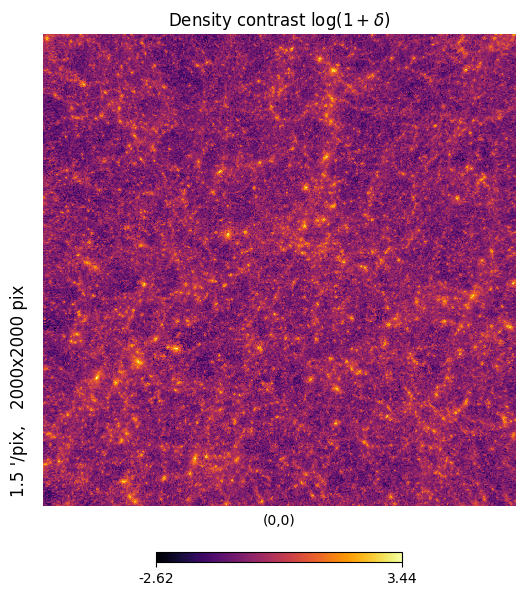

In [22]:
#Projection gnomonic
hp.gnomview(np.log(1.001+density_contrast), title="Density contrast $\log(1+\delta)$", cmap="inferno", reso=1.5, xsize=2000, rot=[0, 0, 0])
plt.show()

In [23]:
#Building the convergence map using GLASS
import glass.fields
import glass.points
import glass.shapes
import glass.lensing
import glass.observations
import glass.galaxies
import glass.ext.camb
import camb
from classy import Class
from cosmology import Cosmology

from scipy.optimize import minimize_scalar

In [24]:
path_info = "/n17data/sguerrini/GowerStreetSims/PKDGRAV3_on_DiRAC_DES_330 - Sheet1.csv"

cosmo_params = read_cosmo_params(path_info, sim)

In [25]:
cosmo_params

{'h': array([0.71654738]),
 'Omega_m': array([0.24962876]),
 'Omega_b': array([0.04350883]),
 'sigma_8': array([0.95049616]),
 'n_s': array([0.95131107]),
 'w': array([-0.7924174]),
 'm_nu': array([0.06]),
 'A_s': array([3.93260771e-09])}

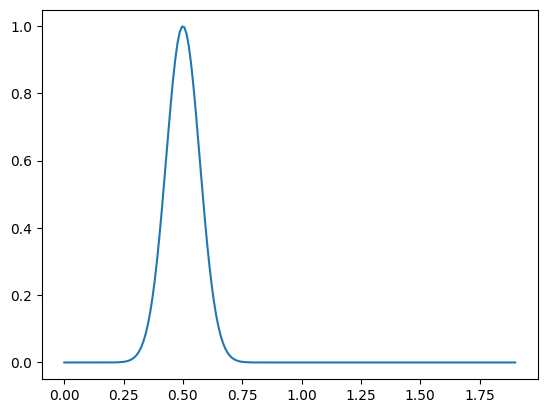

In [26]:
#Load the redshift distribution
z = np.linspace(0., 1.9, 200)
dndz = np.exp(-(z - 0.5)**2 / 0.1**2)

plt.figure()

plt.plot(z, dndz)

plt.show()

In [27]:
#Load parameters for the cosmology
h = cosmo_params["h"]
Om = cosmo_params["Omega_m"]
Ob = cosmo_params["Omega_b"]
Oc = Om - Ob
ns = cosmo_params["n_s"]
m_nu = cosmo_params["m_nu"]
w = cosmo_params["w"]
As = cosmo_params["A_s"]

nside=512
lmax = 3*nside

pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)

cosmo = Cosmology.from_camb(pars)

#Initialize the weight for the shells (tophat window)
weights = glass.shells.tophat_windows(shells)

#The generatorfor the convergence field
convergence = glass.lensing.MultiPlaneConvergence(cosmo)

#Load the redshift distribution
z = np.linspace(shells[0], shells[-1], 200)
dndz = np.exp(-(z - 0.5)**2 / 0.1**2)

#the integrated convregence and shear field over the redshift distribution
kappa_bar = np.zeros(hp.nside2npix(nside))
gamm1_bar = np.zeros(hp.nside2npix(nside))
gamm2_bar = np.zeros(hp.nside2npix(nside))

#main loop to simulate the convergence from the matter fields
for i, weight in tqdm(enumerate(weights)):
    run = 100 - i

    #Load the density contrast
    path_exist, path = get_path_lightcone(sim, run)
    assert path_exist, f"The path {path} to the lightcone does not exist."

    n_gal = np.load(path, allow_pickle=True)
    density_i = n_gal / np.mean(n_gal) - 1
    density_i = downgrade_lightcone(density_i, 512)
    del n_gal

    #add lensing plane from the window function of this shell
    convergence.add_window(density_i, weight)

    #compute convergence field
    kappa_i = convergence.kappa

    #Compute the shear field
    gamma1_i, gamma2_i = glass.lensing.shear_from_convergence(kappa_i)

    #Get the restriction of the dndz to this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, weight)

    #compute the galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)

    #Add to mean fields using the galaxy number density as wieght
    kappa_bar += ngal * kappa_i
    gamm1_bar += ngal * gamma1_i
    gamm2_bar += ngal * gamma2_i

#compute the overall galaxy density
ngal = np.trapz(dndz, z)

#normalise mean fields by the total galaxy number density
kappa_bar /= np.sum(ngal)
gamm1_bar /= np.sum(ngal)
gamm2_bar /= np.sum(ngal)

76it [07:17,  5.76s/it]


In [29]:
#get the angular power spectra of the lensing map
sim_cls = hp.anafast([kappa_bar, gamm1_bar, gamm2_bar], pol=True, lmax=lmax, use_pixel_weights=True)

#getthe expected cl's from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

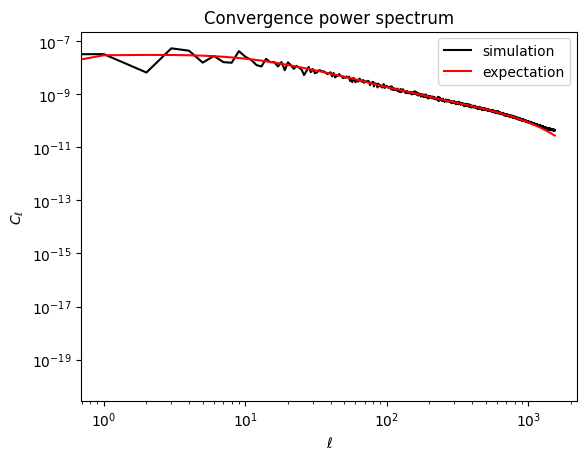

/tmp/ipykernel_1302865/1878486090.py:23: RuntimeWarning: divide by zero encountered in divide
  plt.plot(l, sim_cls[0]/theory_cls['W1xW1']/pw**2)


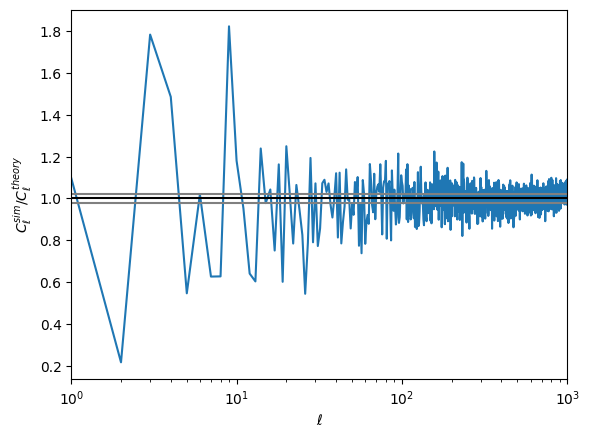

In [36]:
plt.figure()

#get the HEALPix pixel window function since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

l = np.arange(lmax+1)
plt.plot(l, sim_cls[0], label="simulation", c='k')
plt.plot(l, theory_cls['W1xW1']*pw**2, label="expectation", c='r')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("Convergence power spectrum")

plt.show()

plt.figure()

plt.plot(l, sim_cls[0]/theory_cls['W1xW1']/pw**2)
plt.axhline(1, color='k')
plt.axhline(1.02, color='gray')
plt.axhline(0.98, color='gray')

plt.xscale('log')

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell^{sim}/C_\ell^{theory}$")
plt.xlim(1, 1e3)

plt.show()

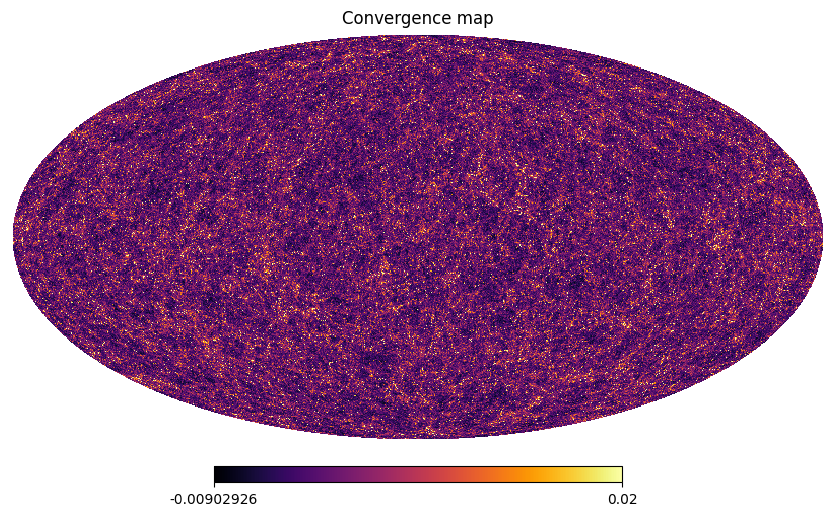

In [37]:
hp.mollview(kappa_bar, max=0.02, title="Convergence map", cmap="inferno")
plt.show()

In [34]:
np.sum(np.ones_like(kappa_bar)[kappa_bar>0.02])/hp.nside2npix(nside)

0.010805447896321615

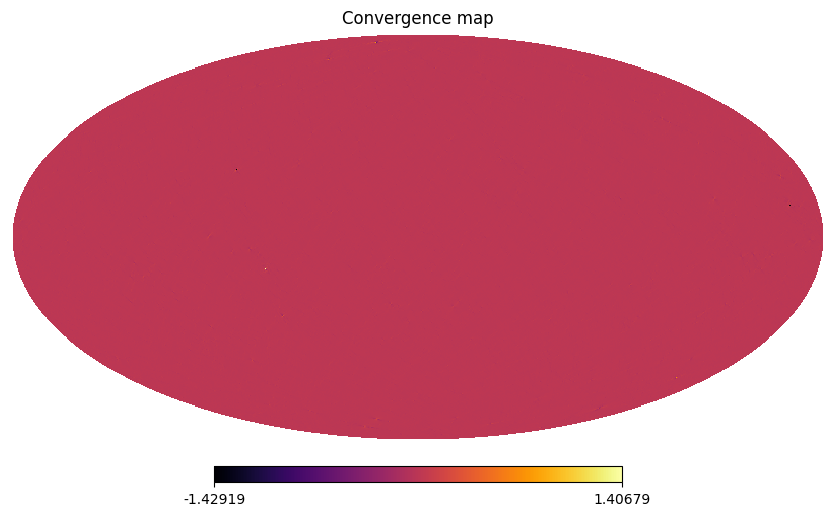

In [54]:
path_exist, path = get_path_lightcone(sim, 100)
assert path_exist, f"The path {path} to the lightcone does not exist."

n_gal = np.load(path, allow_pickle=True)
#n_gal = downgrade_lightcone(n_gal, nside)
density_i = n_gal / np.mean(n_gal) - 1

hp.mollview(gamm2_bar, title="Convergence map", cmap="inferno")

plt.show()

In [48]:
kappa_bar_test = np.array([kappa_bar[i] if np.abs(kappa_bar[i])<0.1 else 0 for i in range(len(kappa_bar))])

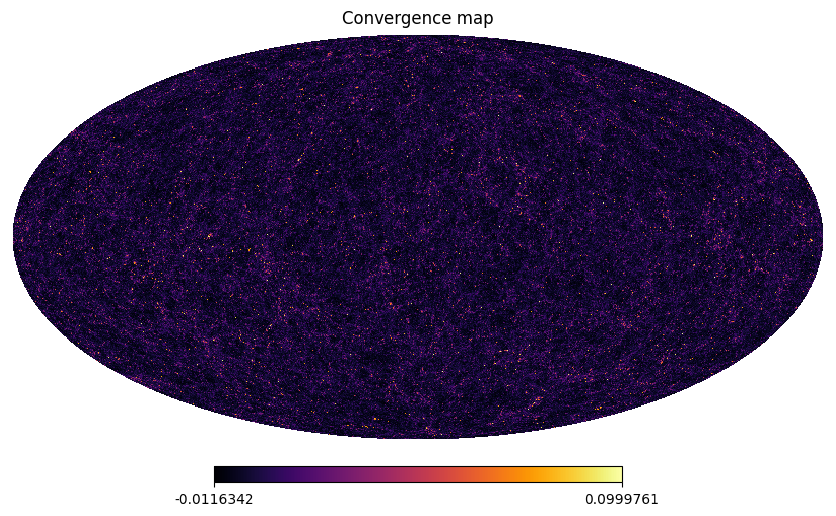

In [49]:
hp.mollview(kappa_bar_test, title="Convergence map", cmap="inferno")
plt.show()

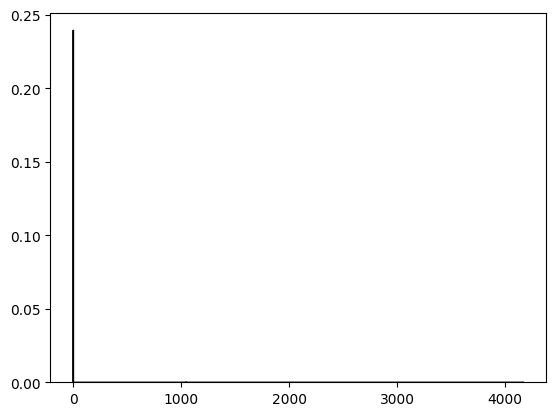

In [42]:
path_exists, path = get_path_lightcone(sim, 100)
assert path_exists, f"The path {path} does not exist."
n_gal = np.load(path, allow_pickle=True)
density_i = n_gal / np.mean(n_gal) - 1

plt.figure()

plt.hist(density_i, bins=1000, density=True, histtype="step", color="black")
plt.show()

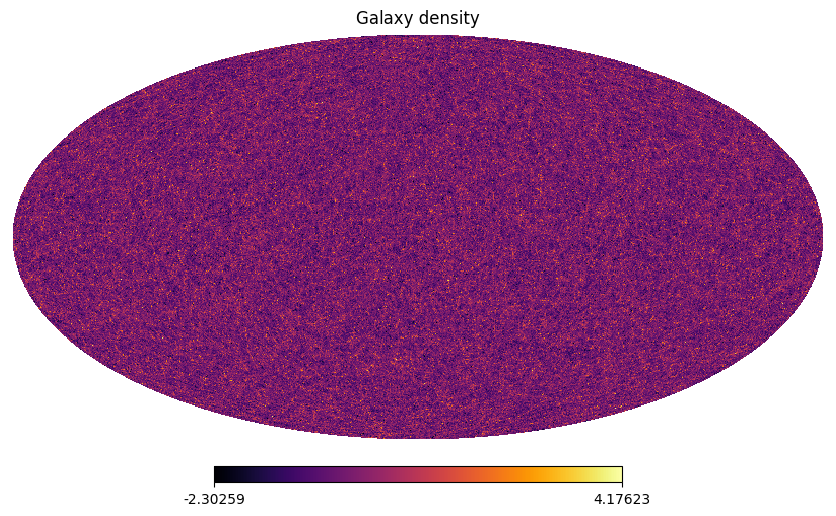

In [185]:
hp.mollview(np.log(n_gal/np.mean(n_gal)+0.1), title="Galaxy density", cmap="inferno")
plt.show()

In [188]:
np.sum(n_gal)

63584

In [ ]:
kappa_i 

In [146]:
z = np.linspace(0, 1.9854, 3000)
dndz = np.exp(-(z - 0.5)**2 / 0.1**2)

z_i, dndz_i = glass.shells.restrict(z, dndz, weights[0])

In [147]:
np.trapz(dndz_i, z_i)

2.2954953513324876e-13

In [148]:
from scipy.integrate import quad

quad(lambda z: np.exp(-(z - 0.5)**2 / 0.1**2), np.min(z_i), np.max(z_i))

(2.2946847398954714e-13, 2.5476118324879408e-27)

In [153]:
pw

array([1.        , 0.99999978, 0.99999927, ..., 0.64692993, 0.64654642,
       0.64616284], dtype='>f8')

### Explore csv with values of the cosmological parameters

In [21]:
import pandas as pd

In [24]:
info = pd.read_csv("/n17data/sguerrini/GowerStreetSims/PKDGRAV3_on_DiRAC_DES_330 - Sheet1.csv", header=1)

In [48]:
line = info.loc[info["Serial Number"]==100]

In [51]:
line['w'].values

array([-1.07976924])